# Skapa stdScaler för alla kryptovalutor som vi använder

In [1]:
import pandas as pd
import numpy as np
import time
from pandas.tseries.offsets import DateOffset
from binance.client import Client
from datetime import datetime as dt
import os
from sklearn.preprocessing import StandardScaler
import pickle
import joblib
import matplotlib.pyplot as plt
import yfinance as yf
import preprocess as pp


### GOLD

In [2]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)

    # Behåll endast 'Close' priser och döp om kolumnen till 'GLDUSDT'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})

    df_dates = pd.DataFrame(pd.date_range(start=gld_data.index[0], end=pd.to_datetime( # type: ignore
        'today').date(), freq='D'), columns=['Date'])  # type: ignore

    df_dates.set_index('Date', inplace=True)
    gld_data = df_dates.merge(gld_data, how='left',
                              left_on='Date', right_index=True)
    # interpolating missing values
    gld_data.interpolate(method='linear', inplace=True)
    return gld_data




In [3]:
df_gold = get_gold_data()

### Inflation

In [4]:
def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(
        id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(
        str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(
        inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(
        chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


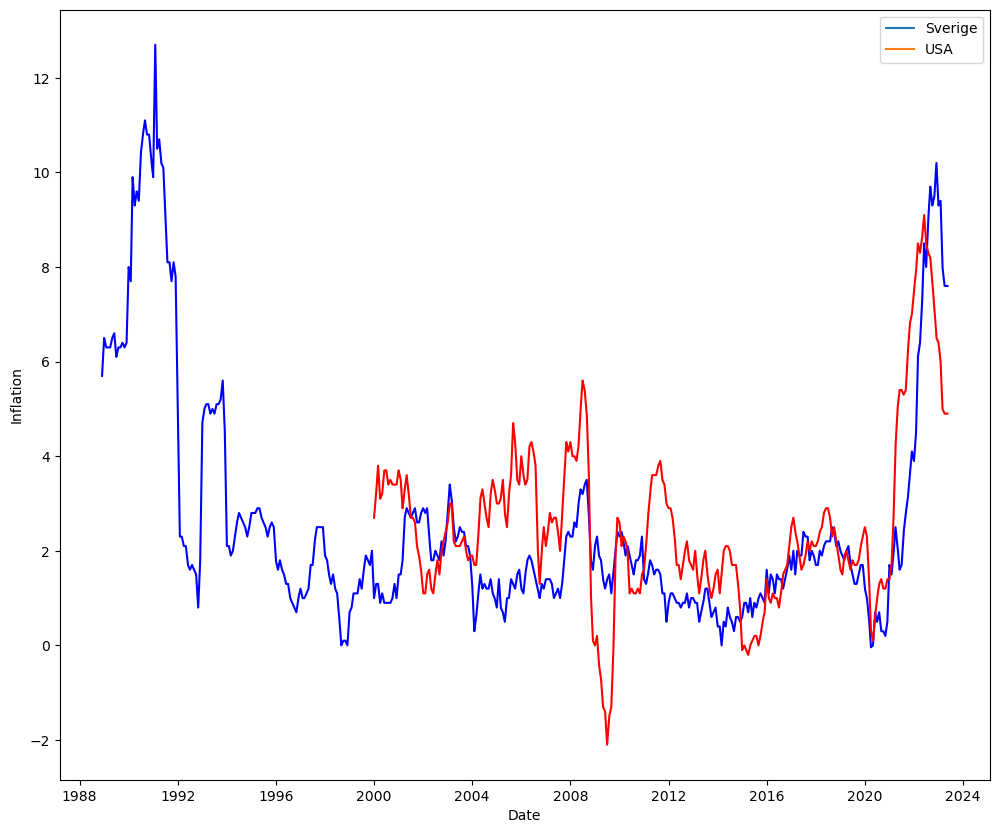

In [5]:

def get_inflation_data(graph=False):
    # Explain this function here
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])

    US_inflation = pd.read_html(
        'https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$',
                         value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    # SE_inflation = pd.DataFrame()
    SE_inflation = pd.read_html(
        'https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')

    SE_inflation = initiate_data(
        SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    # SE_inflation is in percent, divide by 10 to get decimal
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10
    US_inflation = initiate_data(
        US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index,
                SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        # make the lines blue and red
        ax.lines[0].set_color('blue')
        ax.lines[1].set_color('red')
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1).copy()
    inflations = inflations.dropna()
    # inflations = add_horizon_columns(inflations, [75, 90, 250])
   
    return inflations


df_infl = get_inflation_data(graph=True)
# only keep US_inflation
df_infl = df_infl[['US_inflation']]

### applicera StandardScaler på alla kolumner (tickers) i df
Använd en .py som skapar nya kolumner och preprocessar data - samma .py överallt
StandardScaler får inte ha NaN's
Skapa en folder för alla StandardScalers som sparas

In [6]:
# Gör en funktion som applicerar StandardScaler() på en ticker och sparar den i en fil uppbyggd av namnet  på ticker.

def fit_and_save_scaler(df, column_name):
    # Kontrollera att kolumnnamnet finns i DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Kolumnen '{column_name}' finns inte i DataFrame")

    # Skapa och träna en StandardScaler med den givna kolumnen
    scaler = StandardScaler()
    scaler.fit(df[[column_name]])

    # Spara StandardScaler i en fil
    file_name = f"scalers/{column_name}_scaler.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(scaler, f)

    print(f"StandardScaler för kolumn '{column_name}' sparad som '{file_name}'")


### Skapa en StandardScaler för alla 'godkända' kolumner i df

In [7]:
# läs in ticker-names från filen yf_tickers.txt
filnamn = 'yf_tickers.txt'
def read_ticker_names(filenam):  
    with open(filenam, 'r') as f:
        ticker_names = f.read().splitlines()
    return ticker_names


In [8]:
# hämta yf_tickers från yfinance
def get_yf_data(tickers, time_period='2y'):
    # Hämta historiska data från yfinance
    # yf_data = yf.download(tickers, start='2019-01-01', end=dt.today().date(), progress=False)
    yf_data = yf.download(tickers, interval='1d',
                       period=time_period, group_by='ticker', auto_adjust=True, progress=True)

    df_cur = pd.DataFrame(yf_data.xs('Close', axis=1, level=1)) 
    df_vol = pd.DataFrame(yf_data.xs('Volume', axis=1, level=1)) 
    # # Sätt kolumnnamn till tickers
    # yf_data.columns = tickers
    return df_cur, df_vol
# df_curr,df_vol= get_yf_data(yf_ticker_names)


In [9]:
# Alternativt sätt att få df
if False:
    df = pd.read_csv('all_tickers.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    print(df.shape)

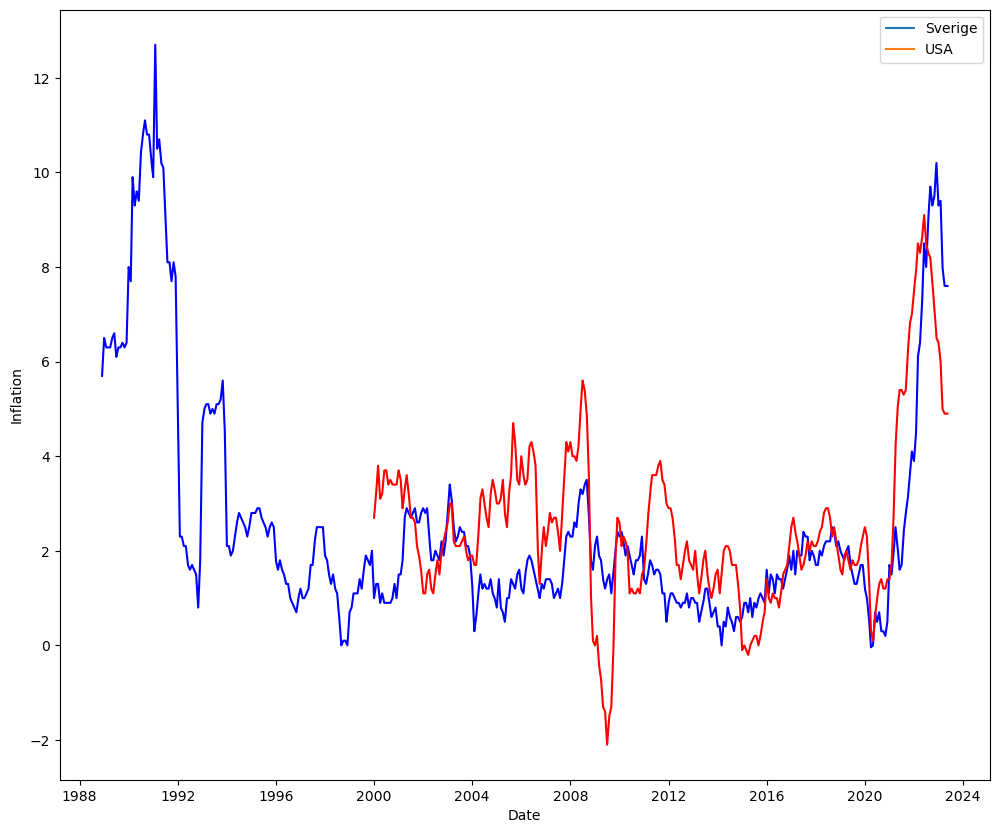

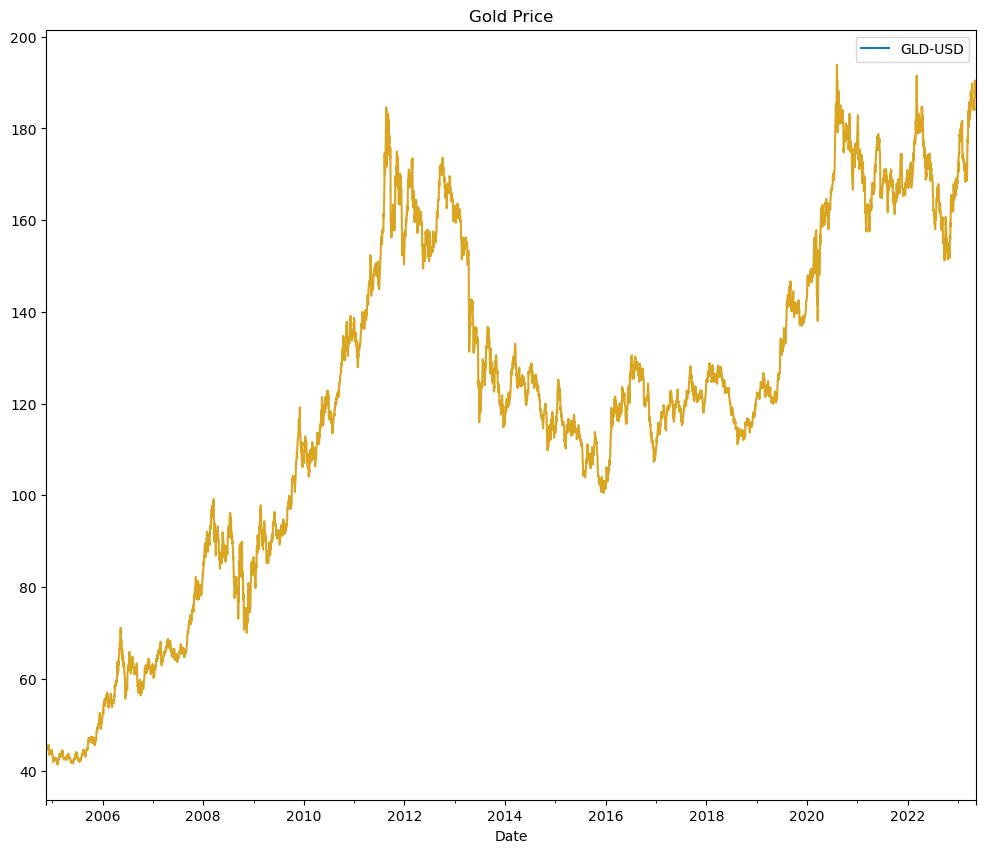

In [10]:
### Hämta US inflation
df_infl = get_inflation_data(graph=True)
# only keep US_inflation
df_infl = df_infl[['US_inflation']]
df_infl.to_csv('inflation.csv')

# Hämta guldpriser
df_gold = get_gold_data()
df_gold.plot(figsize=(12, 10), title='Gold Price')
# make the line golden
plt.gca().lines[0].set_color("goldenrod")
plt.show()
df_gold.to_csv('gold.csv')


In [11]:
# Hämta och skapa två DataFrame (currencies och Volumes) med alla tickers från yfinance
filnamn = 'yf_tickers.txt'
yf_ticker_names = read_ticker_names(filnamn)
print(f'{len(yf_ticker_names)} yFinance ticker_names inlästa')
df_curr,df_vol = get_yf_data(yf_ticker_names)
display(df_curr.shape)
display(df_vol.shape)


321 yFinance ticker_names inlästa
[*********************100%***********************]  321 of 321 completed


(731, 321)

(731, 321)

### Spara undan df som csv

In [12]:
# spara undan df som csv
if True:
    df_curr.to_csv('df_curr.csv', index=True)
    df_vol.to_csv('df_vol.csv', index=True)

In [13]:
# läs in df från csv
if True:
    df_curr =   pd.read_csv('df_curr.csv', index_col=0) 
    df_curr.index = pd.to_datetime(df_curr.index)
    df_vol = pd.read_csv('df_vol.csv', index_col=0)
    df_vol.index = pd.to_datetime(df_vol.index)

### Kör preprocessing

In [14]:
display(df_curr.iloc[:,:5].head(3))
print(df_curr.shape)
display(df_vol.iloc[:,:5].head(3))
df_vol.shape

,ALPACA-USD,FIO-USD,OG-USD,AMP-USD,AGIX-USD
Date,,,,,
2021-05-15,1.681685,0.293952,11.689155,0.061567,0.369882
2021-05-16,1.409008,0.282282,12.107766,0.059746,0.346209
2021-05-17,1.318942,0.259739,10.096737,0.056212,0.327826


(731, 321)


,ALPACA-USD,FIO-USD,OG-USD,AMP-USD,AGIX-USD
Date,,,,,
2021-05-15,3139587,7235861,38862597,4892483,16958821
2021-05-16,4230420,9145522,62472023,5277504,7148182
2021-05-17,4128182,5380039,20932673,6252428,3954438


(731, 321)

In [15]:
# preprocess all of df
df_dict={}
df_curr = pp.preprocessing_currency(df_curr)
df_vol = pp.preprocessing_currency(df_vol)
if df_curr is not None and df_vol is not None:
    assert df_curr.shape[1] == df_vol.shape[1],'The number of columns in df_curr and df_vol are not the same'
    assert df_curr.columns.values.tolist() == df_vol.columns.values.tolist(),'The columns in df_curr and df_vol are not the same'
    print('Antal currency NaN',df_curr.isna().any().sum())
    print('Antal Volume NaN', df_vol.isna().any().sum())
    print()
    df_dict = {}  # en dictionary med samtlig nya dataframes
    for cnt, column_name in enumerate(df_curr.columns):
        df_name = f'df_{column_name}'
        df_dict[df_name]   = pp.preprocess(df_curr[[column_name]], df_vol[[column_name]], df_gold, df_infl)
        # for each 10th column, print the name
        if (cnt+1) % 10 == 0:
            print(cnt+1,column_name)
    
    
display(df_dict.keys())


321 kolumner totalt
321 kolumner, var och en, med 657 eller fler rader utan nan efter dropna
368 rader med någon nan 
720 rader utan nan
Efter interpollate: 0 rader med någon nan 
731 rader utan nan
(731, 321)
321 kolumner totalt
321 kolumner, var och en, med 657 eller fler rader utan nan efter dropna
368 rader med någon nan 
720 rader utan nan
Efter interpollate: 0 rader med någon nan 
731 rader utan nan
(731, 321)
Antal currency NaN 0
Antal Volume NaN 0

10 RVN-USD
20 BTCDOWN-USD
30 PAXG-USD
40 ARDR-USD
50 QTUM-USD
60 PROM-USD
70 DOT-USD
80 BADGER-USD
90 ADAUP-USD
100 GAS-USD
110 MDT-USD
120 SLP-USD
130 VTHO-USD
140 LTC-USD
150 LOOM-USD
160 EGLD-USD
170 QKC-USD
180 OGN-USD
190 POND-USD
200 AERGO-USD
210 ADA-USD
220 BAR-USD
230 EPS-USD
240 FLUX-USD
250 RAMP-USD
260 RNDR-USD
270 BOND-USD
280 ANT-USD
290 TFUEL-USD
300 VGX-USD
310 BTT-USD
320 CVX-USD


dict_keys(['df_ALPACA-USD', 'df_FIO-USD', 'df_OG-USD', 'df_AMP-USD', 'df_AGIX-USD', 'df_MITH-USD', 'df_SC-USD', 'df_BAKE-USD', 'df_ONT-USD', 'df_RVN-USD', 'df_COTI-USD', 'df_FUN-USD', 'df_BLZ-USD', 'df_UMA-USD', 'df_FLM-USD', 'df_REEF-USD', 'df_DEGO-USD', 'df_ZEC-USD', 'df_QNT-USD', 'df_BTCDOWN-USD', 'df_POLY-USD', 'df_FIL-USD', 'df_VIB-USD', 'df_1INCH-USD', 'df_HNT-USD', 'df_AXS-USD', 'df_USDP-USD', 'df_ICP-USD', 'df_ALICE-USD', 'df_PAXG-USD', 'df_AVA-USD', 'df_MIR-USD', 'df_USTC-USD', 'df_WNXM-USD', 'df_ATM-USD', 'df_FLOW-USD', 'df_GHST-USD', 'df_DENT-USD', 'df_FXS-USD', 'df_ARDR-USD', 'df_TRB-USD', 'df_XRPUP-USD', 'df_AR-USD', 'df_LSK-USD', 'df_NMR-USD', 'df_LINK-USD', 'df_ADX-USD', 'df_PERP-USD', 'df_ZEN-USD', 'df_QTUM-USD', 'df_SFP-USD', 'df_RUNE-USD', 'df_MBL-USD', 'df_XVS-USD', 'df_SUSHI-USD', 'df_EOS-USD', 'df_WAN-USD', 'df_QUICK-USD', 'df_WAVES-USD', 'df_PROM-USD', 'df_ICX-USD', 'df_GAL-USD', 'df_SAND-USD', 'df_ATA-USD', 'df_INJ-USD', 'df_SOL-USD', 'df_FOR-USD', 'df_PHA-USD', 

In [16]:
# print första elementet i df_dict
first_key = list(df_dict.keys())[0]
display(df_dict[first_key])

,ALPACA-USD,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,...,infl_Ratio_90,infl_Ratio_250,GLD-USD,GLD_Ratio_2,GLD_Ratio_5,GLD_Ratio_30,GLD_Ratio_60,GLD_Ratio_90,GLD_Ratio_250,diff
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-16,1.409008,0.911775,1.409008,0.911775,1.409008,0.911775,1.409008,0.911775,1.409008,0.911775,...,1.318073,2.242523,174.029999,1.001929,1.009877,1.032239,1.051471,1.056306,1.012534,0.000000
2021-05-17,1.318942,0.966984,1.363975,0.897314,1.363975,0.897314,1.363975,0.897314,1.363975,0.897314,...,1.310174,2.233207,174.699997,1.001921,1.008765,1.034474,1.054230,1.059911,1.016629,0.000000
2021-05-18,1.325037,1.002305,1.321989,0.924229,1.350996,0.924229,1.350996,0.924229,1.350996,0.924229,...,1.302477,2.223939,175.039993,1.000972,1.006185,1.034650,1.055030,1.061351,1.018784,0.029006
2021-05-19,0.906507,0.812448,1.115772,0.682490,1.239873,0.682490,1.239873,0.682490,1.239873,0.682490,...,1.294976,2.214719,175.160004,1.000343,1.004024,1.033472,1.054482,1.061446,1.019655,0.124101
2021-05-20,1.184111,1.132786,1.045309,0.963694,1.228721,0.907911,1.228721,0.907911,1.228721,0.907911,...,1.287665,2.205548,175.960007,1.002278,1.005612,1.036260,1.057931,1.065652,1.024479,0.183412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-11,0.204976,0.960604,0.213383,0.937421,0.218660,0.781236,0.262374,0.728027,0.281550,0.711086,...,0.978897,0.790578,187.130005,0.995690,0.995157,1.003995,1.011900,1.037730,1.100816,0.074875
2023-05-12,0.209260,1.010342,0.207118,0.982696,0.212945,0.808680,0.258768,0.747214,0.280054,0.727848,...,0.980514,0.792239,186.809998,0.999144,0.994305,1.002347,1.009355,1.035079,1.098209,0.080387
2023-05-13,0.205225,0.990265,0.207243,0.970606,0.211440,0.803170,0.255519,0.737485,0.278277,0.715991,...,0.982058,0.793899,186.809998,1.000000,0.995237,1.002868,1.008449,1.034186,1.097480,0.079388


In [17]:
# create a function that loops throug all keys in df_dict and makes fit of the values with StandardScaler.
# Save the scaler object to a file with the name of the key.
# first iclude the libraries needed
from sklearn.preprocessing import StandardScaler
import pickle

def scale_data(df_dict):
    idx=-1
    for idx, key in enumerate(df_dict.keys()):
        scaler = StandardScaler()
        scaler.fit(df_dict[key])  # scaler for all columns including currency-close value
        
        # Spara StandardScaler i en fil
        file_name = f"scalers/{key}_scaler.pkl"
        with open(file_name, 'wb') as f:
            pickle.dump(scaler, f)
        if (idx+1)%20==0:
            print(f"nr {idx+1}: StandardScaler för '{key}' sparad som '{file_name}'")
    print(f"All done! {idx+1} StandardScaler sparade")  
scale_data(df_dict)

nr 20: StandardScaler för 'df_BTCDOWN-USD' sparad som 'scalers/df_BTCDOWN-USD_scaler.pkl'
nr 40: StandardScaler för 'df_ARDR-USD' sparad som 'scalers/df_ARDR-USD_scaler.pkl'
nr 60: StandardScaler för 'df_PROM-USD' sparad som 'scalers/df_PROM-USD_scaler.pkl'
nr 80: StandardScaler för 'df_BADGER-USD' sparad som 'scalers/df_BADGER-USD_scaler.pkl'
nr 100: StandardScaler för 'df_GAS-USD' sparad som 'scalers/df_GAS-USD_scaler.pkl'
nr 120: StandardScaler för 'df_SLP-USD' sparad som 'scalers/df_SLP-USD_scaler.pkl'
nr 140: StandardScaler för 'df_LTC-USD' sparad som 'scalers/df_LTC-USD_scaler.pkl'
nr 160: StandardScaler för 'df_EGLD-USD' sparad som 'scalers/df_EGLD-USD_scaler.pkl'
nr 180: StandardScaler för 'df_OGN-USD' sparad som 'scalers/df_OGN-USD_scaler.pkl'
nr 200: StandardScaler för 'df_AERGO-USD' sparad som 'scalers/df_AERGO-USD_scaler.pkl'
nr 220: StandardScaler för 'df_BAR-USD' sparad som 'scalers/df_BAR-USD_scaler.pkl'
nr 240: StandardScaler för 'df_FLUX-USD' sparad som 'scalers/df_FLU

In [18]:
df_dict['df_HC-USD'].head()

,HC-USD,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,...,infl_Ratio_90,infl_Ratio_250,GLD-USD,GLD_Ratio_2,GLD_Ratio_5,GLD_Ratio_30,GLD_Ratio_60,GLD_Ratio_90,GLD_Ratio_250,diff
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-16,1.651052,0.981792,1.651052,0.981792,1.651052,0.981792,1.651052,0.981792,1.651052,0.981792,...,1.318073,2.242523,174.029999,1.001929,1.009877,1.032239,1.051471,1.056306,1.012534,0.000000
2021-05-17,1.504635,0.953602,1.577843,0.927265,1.577843,0.927265,1.577843,0.927265,1.577843,0.927265,...,1.310174,2.233207,174.699997,1.001921,1.008765,1.034474,1.054230,1.059911,1.016629,0.000000
2021-05-18,1.533048,1.009354,1.518842,0.958002,1.562912,0.958002,1.562912,0.958002,1.562912,0.958002,...,1.302477,2.223939,175.039993,1.000972,1.006185,1.034650,1.055030,1.061351,1.018784,0.044070
2021-05-19,1.030589,0.804005,1.281819,0.693382,1.429831,0.693382,1.429831,0.693382,1.429831,0.693382,...,1.294976,2.214719,175.160004,1.000343,1.004024,1.033472,1.054482,1.061446,1.019655,0.148012
2021-05-20,1.156375,1.057516,1.093482,0.840915,1.375140,0.807902,1.375140,0.807902,1.375140,0.807902,...,1.287665,2.205548,175.960007,1.002278,1.005612,1.036260,1.057931,1.065652,1.024479,0.281658


### Kör allt tom hit

### Alternativ. Hämta valutor från Binance med asyncio för ipynb

In [19]:
if False:
    # Hämta kryptovalutor asynkront för en ipynb-fil
    import pandas as pd
    from datetime import datetime
    from binance.client import Client
    import httpx
    import asyncio
    # set timer
    start_time = datetime.now()

    # Ange din API-nyckel och hemliga nyckel från Binance här
    api_key = '2jxiCQ8OIWmU4PZH4xfwKEY9KYerDkSWzwNCqoaMzj41eJgWBsSqA3VYqkt2wmdX'
    api_secret = 'YY1Qj1t0JZrE4tQdaBBxT8iwl2tbFalWp1FHjyZ9selBb6OnQ0Oj8aVdiXO7YLMz'

    # Ange valutorna du vill ladda ner
    cryptos = ['BTCUSDT', 'ETHUSDT', 'BCHUSDT', 'XRPUSDT', 'ZRXUSDT',
            'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'AVAXUSDT']


    async def get_historical_klines_async(symbol):
        base_url = "https://api.binance.com"
        interval = "1d"
        _24_months_in_seconds = int(24 * 30.44 * 24 * 60 * 60)
        
        # Current timestamp in milliseconds
        end_time = int(datetime.now().timestamp() * 1000)
        # 24 months ago timestamp in milliseconds
        start_time = end_time - (_24_months_in_seconds * 1000)
        url = f"{base_url}/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}"
        async with httpx.AsyncClient() as client:
            response = await client.get(url)
        return response.json()


    async def main():
        tasks = [get_historical_klines_async(symbol) for symbol in cryptos]
        klines = await asyncio.gather(*tasks)

        close_prices_list = []
        timestamps_list = []
        for crypto_data in klines:
            close_prices = [float(kline[4]) for kline in crypto_data]
            timestamps = [int(kline[0]) for kline in crypto_data]
            close_prices_list.append(close_prices)
            timestamps_list.append(timestamps)

        # Konvertera close_prices_list till en pandas DataFrame
        data = {symbol: prices for symbol,
                prices in zip(cryptos, close_prices_list)}
        df = pd.DataFrame(data)

        # Hämta tidpunkterna för varje datapunkt och konvertera dem till datetime-objekt
        dates = pd.to_datetime(timestamps_list[0], unit='ms')

        # Sätt Date som index för DataFrame
        df.index = dates

        # Visa DataFrame
        display(df)

    # Kör asynkron kod i Jupyter Notebook
    await main()

    # print the elapsed time  
    elapsed_time = datetime.now() - start_time 
    # round to seconds
    elapsed_seconds = round(elapsed_time.total_seconds(),1)

    print('elapsed time',elapsed_seconds,)
#%%


### En lista över alla tillgängliga kryptovalutor i Binance

In [ ]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
unique_cryptos = {}
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    symbols_data = data["symbols"]

    # Extrahera unika kryptovalutor från handelsparen
    unique_cryptos = set()
    for symbol_info in symbols_data:
        base_asset = symbol_info["baseAsset"]
        quote_asset = symbol_info["quoteAsset"]
        unique_cryptos.add(base_asset)
        unique_cryptos.add(quote_asset)

    print("Unique cryptocurrencies on Binance:", unique_cryptos)
else:
    print("Failed to fetch exchange info")

print(len(unique_cryptos))
# a list comprahension that selects all including USD
[ crypto for crypto in unique_cryptos if 'USD' in crypto]
